# 5 Flower Types Classification Dataset

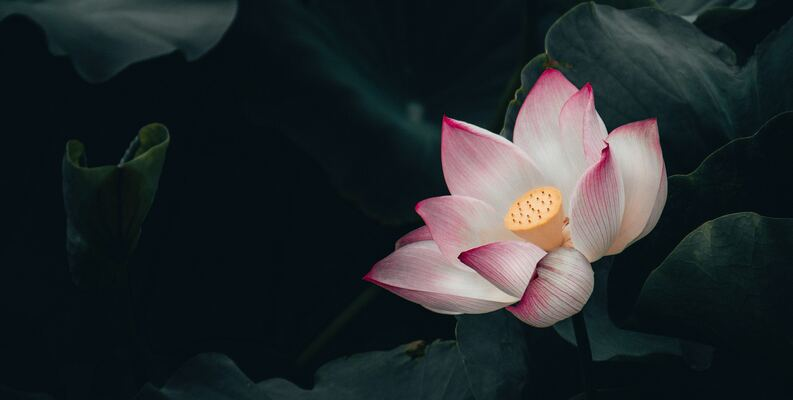


# Import needed modules

In [ ]:
!pip install tensorflow

In [ ]:
pip install kagglehub --upgrade

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

### **Read data and store it in dataframe**

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
path_to_data = os.path.join(path, "flower_images")
print("Path to dataset files:", path_to_data)

Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/flower_images


In [16]:
# List all folders in the data directory
folders = os.listdir(path_to_data)

# Collect file paths and labels
data = []
for folder in folders:
    folder_path = os.path.join(path_to_data, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        data.append((file_path, folder))

# Create a dataframe from the collected data
df = pd.DataFrame(data, columns=["filepaths", "labels"])


In [ ]:
df

### **Split dataframe into train, valid, and test**

In [20]:
# Split data into training, validation, and test sets in one step
train_df, valid_test_df = train_test_split(df, train_size=0.8, random_state=123)
valid_df, test_df = train_test_split(valid_test_df, train_size=0.6, random_state=123)


### **Create image data generator**

## image augmentation

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Load an example image
img = load_img("example.jpg")  # Replace with the path to an image
x = img_to_array(img)          # Convert to numpy array
x = x.reshape((1,) + x.shape)  # Add batch dimension

# Create an ImageDataGenerator with simple augmentations
datagen = ImageDataGenerator(
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Shift image horizontally
    height_shift_range=0.2,  # Shift image vertically
    shear_range=0.2,         # Apply shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Flip images horizontally
    fill_mode="nearest"      # Fill in missing pixels
)

# Generate and visualize augmented images
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i == 4:  # Show 4 augmented images
        break
plt.show()


```

| **Transformation**        | **Description**                                                                 |
|---------------------------|---------------------------------------------------------------------------------|
| `rotation_range`           | Rotate images randomly within the specified degree range.                       |
| `width_shift_range`        | Shift images horizontally by a fraction of the total width.                    |
| `height_shift_range`       | Shift images vertically by a fraction of the total height.                     |
| `shear_range`              | Apply shear transformations.                                                   |
| `zoom_range`               | Randomly zoom into images.                                                     |
| `horizontal_flip`          | Flip images horizontally.                                                      |
| `vertical_flip`            | Flip images vertically.                                                        |
| `rescale`                  | Scale pixel values (e.g., 1.0/255 to normalize to [0, 1]).                      |
| `preprocessing_function`   | Apply a custom preprocessing function to images.                                |
| `fill_mode`                | Fill pixels outside image boundaries. Common values: `nearest`, `constant`.    |


In [22]:
# Define image and batch settings
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Compute test batch size based on test data length
test_batch_size = min(len(test_df), 80)
test_steps = len(test_df) // test_batch_size

# Simple function for data augmentation (currently just returns the image)
def scalar(img):
    return img

# Create image data generators with preprocessing function
train_gen = ImageDataGenerator(preprocessing_function=scalar)
valid_gen = ImageDataGenerator(preprocessing_function=scalar)
test_gen = ImageDataGenerator(preprocessing_function=scalar)

# Setup data generators for training, validation, and test sets
train_gen = train_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = valid_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = test_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size
)


Found 4000 validated image filenames belonging to 5 classes.
Found 600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


### **Show sample from train data**

In [23]:
# Get class labels and sample a batch
classes = list(train_gen.class_indices.keys())  # Class names
images, labels = next(train_gen)  # Get a batch of images and labels

plt.figure(figsize=(20, 20))

# Plot first 16 images from the batch
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i] / 255)  # Scale image values to [0, 1]

    # Get the class name from the label
    class_name = classes[np.argmax(labels[i])]

    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')  # Hide axes

plt.show()


Output hidden; open in https://colab.research.google.com to view.

# **Model Structure**

#### **Generic Model Creation**

In [24]:
# Model parameters
img_size = (224, 224)
channels = 3
img_shape = (*img_size, channels)  # Image shape
class_count = len(train_gen.class_indices)  # Number of classes

# Create EfficientNetB5 base model, pre-trained on ImageNet
base_model = tf.keras.applications.EfficientNetB5(
    include_top=False, weights='imagenet', input_shape=img_shape, pooling='max'
)
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu',
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006)),
    Dropout(0.45),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,047,548 (110.81 MB)

 Trainable params: 529,925 (2.02 MB)

 Non-trainable params: 28,517,623 (108.79 MB)

#### **Train model**

In [ ]:
batch_size = 16   # set batch size for training
epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

#### **Display model performance**

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 3s 509ms/step - loss: 0.6035 - accuracy: 0.9125
Train Loss:  0.467302143573761
Train Accuracy:  0.9750000238418579
--------------------
Validation Loss:  0.6199498176574707
Validation Accuracy:  0.9125000238418579
--------------------
Test Loss:  0.6034823060035706
Test Accuracy:  0.9125000238418579


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

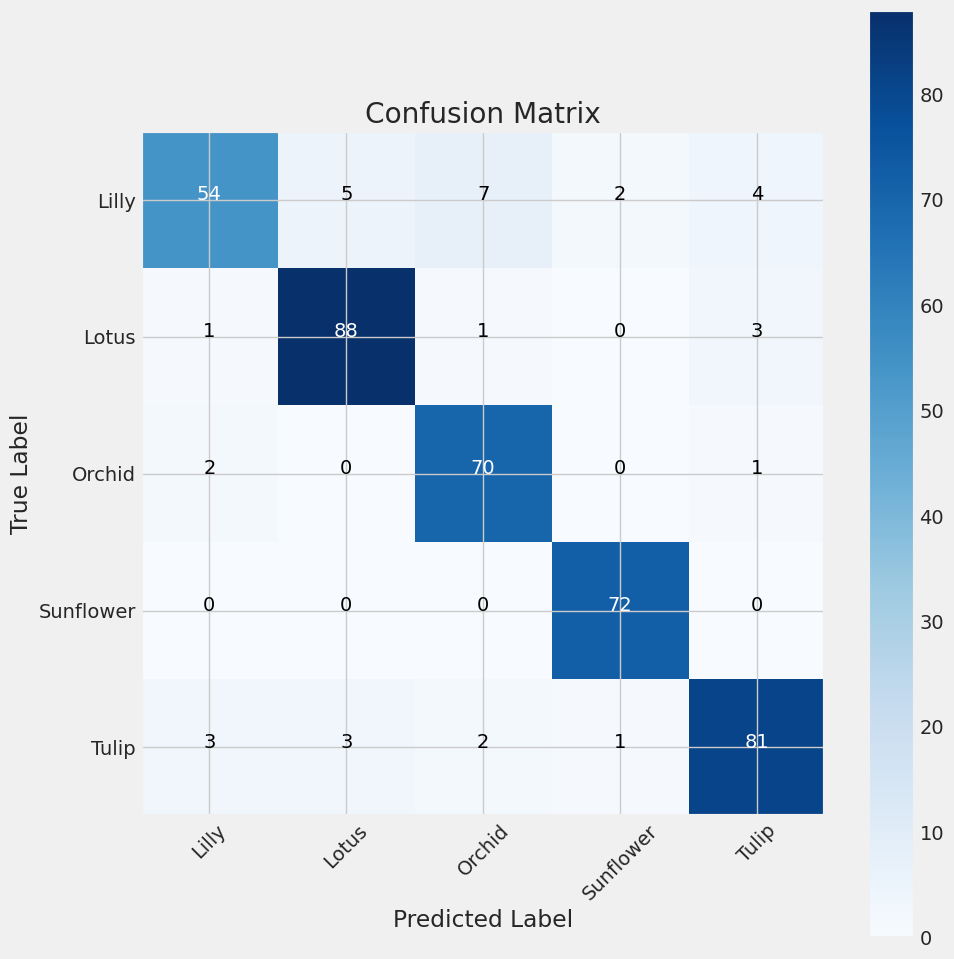

In [ ]:
# Get class labels
classes = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)  # Display matrix with color map
plt.title('Confusion Matrix')
plt.colorbar()  # Show color bar for reference

# Set tick marks and labels for classes
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

# Add numbers inside the matrix cells
threshold = cm.max() / 2  # Set threshold for text color
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = 'white' if cm[i, j] > threshold else 'black'
    plt.text(j, i, cm[i, j], ha='center', color=color)

# Layout and labels
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()


In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Lilly       0.90      0.75      0.82        72
       Lotus       0.92      0.95      0.93        93
      Orchid       0.88      0.96      0.92        73
   Sunflower       0.96      1.00      0.98        72
       Tulip       0.91      0.90      0.91        90

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



#### **Save model**

In [ ]:
model_name = model.input_names[0][:-6]
subject = 'Flower Types'
acc = test_score[1] * 100
save_path = ''

# Save model in .keras format
save_id = str(f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.keras')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights in .keras format
weight_save_id = str(f'{model_name}-{subject}-weights.keras')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')


model was saved as efficientnetb5-Flower Types-91.25.h5
weights were saved as efficientnetb5-Flower Types-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
# Extract class information
class_dict = train_gen.class_indices
img_size = train_gen.image_shape

# Create a DataFrame for class details
class_df = pd.DataFrame({
    'class_index': list(class_dict.values()),
    'class': list(class_dict.keys()),
    'height': img_size[0],
    'width': img_size[1]
})

# Save the DataFrame to a CSV file
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'Class CSV file was saved as {csv_save_loc}')


class csv file was saved as Flower Types-class_dict.csv
